### Analisis exploratorio de KPIs por nico

#### Objetivos

1 - predecir el consumo de energia para 2030 \
2 - predecir la demanda de energia para 2030 de energias renovables

In [1]:
import pandas as pd
import plotly.express as px
import typing as T
from plotly.graph_objects import Figure

In [2]:
data = pd.read_parquet('../datasets/energy_consumption/owid-energy-consumption-source_normalizado.parquet')
data.head()

,pais,anio,pais_iso,poblacion,pbi,biocombustible_cons,biocombustible_elec,biocombustible_share_energia,carbon_intensidad_elec,carbon_cons,...,other_renovable_elec,other_renewable_exc_biocombustible_elec,primary_energia_cons,renovables_cons,renovables_elec,solar_cons,solar_elec,eolica_cons,eolica_elec,eolica_share_energia
0,Afghanistan,1980,AFG,13356500.0,1.532984e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1981,AFG,13171679.0,1.564534e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1982,AFG,12882518.0,1.598041e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1983,AFG,12537732.0,1.675533e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1984,AFG,12204306.0,1.707215e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['pais', 'anio', 'pais_iso', 'poblacion', 'pbi', 'biocombustible_cons',
       'biocombustible_elec', 'biocombustible_share_energia',
       'carbon_intensidad_elec', 'carbon_cons', 'carbon_elec',
       'carbon_produccion', 'elec_demand', 'elec_generation',
       'energia_per_pbi', 'fossil_elec', 'fossil_combustible_cons', 'gas_cons',
       'gas_elec', 'gas_produccion', 'greenhouse_gas_emision_co2s',
       'hydro_cons', 'hydro_elec', 'low_carbon_cons', 'low_carbon_elec',
       'net_elec_imports', 'nuclear_cons', 'nuclear_elec', 'petroleo_cons',
       'petroleo_elec', 'petroleo_produccion', 'other_renovable_cons',
       'other_renovable_elec', 'other_renewable_exc_biocombustible_elec',
       'primary_energia_cons', 'renovables_cons', 'renovables_elec',
       'solar_cons', 'solar_elec', 'eolica_cons', 'eolica_elec',
       'eolica_share_energia'],
      dtype='object')

In [98]:
# Data consumo

class BadEnergies(pd.DataFrame): 
    meta = '' 
    
    def __init__(self, *args, **kwargs):
        return super(BadEnergies, self).__init__(*args, **kwargs)
    
    @property
    def _constructor(self):
        return BadEnergies
    
    def _get_top(self, n):
        data = self.copy()
        add = ['GBR'] if self.meta == 'produccion' else []
        return list(
            data[[i for i in data.columns if i != 'anio']]
            .groupby('pais_iso')
            .mean()
            .sum(axis=1)
            .sort_values(ascending=False)
            .index[:n]
            .values
        ) + add
    
    def _get_melt(self):
        return self.melt(
            id_vars=['pais_iso', 'anio'], 
            value_vars=filter(lambda x: x not in ['pais_iso', 'anio'], self.columns),
            value_name='valor', 
            var_name='tipo_energia'
        )
        
    def get_data(self, filt: T.Literal['cons', 'produccion']):
        BadEnergies.meta = filt
        bad_energies = [
            c 
            for c in self.columns 
            if (
                (
                   'gas' in c
                    or 'petroleo' in c
                    or 'carbon' in c
                    and not 'green' in c
                    and not 'low' in c
                )
            )
        ]
        data = self.copy()
        columns = [i for i in bad_energies if filt in i] + ['pais_iso', 'anio']
        data = data[columns]
        return data
    
    def plot_and_top(self, column, show=False):
        data = self.copy()
        col = column + '_' + self.meta
        fig = px.bar(top_carbon := (
            data[['pais_iso', col]]
            .groupby('pais_iso')
            .mean()
            .sort_values(col, ascending=False)
            .head(10)
        ))
        top_carbon_iso = top_carbon.index
        return fig, top_carbon_iso
    
    def fig_and_table(self, n=10):
        top = self._get_top(n)
        data = (
            self.copy()
            ._get_melt()
            .drop('anio', axis=1)
            .groupby(['pais_iso', 'tipo_energia'])
            .mean()
            .loc[top]
            .reset_index()
        )
        return px.bar(
            data,
            x='pais_iso',
            y='valor',
            color='tipo_energia'
        
        ), data
    
    
    def _get_year(self, year: int) -> pd.DataFrame:
        data = self.copy()
        return (
            data
            .loc[data.anio == year]
            .set_index('pais_iso')
            .loc[data._get_top(10)]
            .reset_index()
            .melt(id_vars=['pais_iso', 'anio'], value_name='valor', var_name='tipo_energia')
            .round(2)
        )
    
    def get_pct_change(self, one: int, two: int):
        data_one = self.copy()._get_year(one)
        data_two = self.copy()._get_year(two) 
        data_pct = data_two.merge(data_one, on=['pais_iso', 'tipo_energia'])
        data_pct['cambio_porcentual'] = (data_pct.valor_x - data_pct.valor_y) / data_pct.valor_y * 100
        return data_pct.round(2)

In [99]:
# Data consumo
data_cons = BadEnergies(data).get_data('cons')
data_cons.head()

,carbon_cons,gas_cons,petroleo_cons,pais_iso,anio
0,NaN,NaN,NaN,AFG,1980
1,NaN,NaN,NaN,AFG,1981
2,NaN,NaN,NaN,AFG,1982
3,NaN,NaN,NaN,AFG,1983
4,NaN,NaN,NaN,AFG,1984


### Top paises carbon, oil, gas
consumo\
production

**Graficas arbitrarias para cada tipo de energia**

In [100]:
# Carbon
carbon_cons_fig, carbon_top_iso = data_cons.plot_and_top('carbon')

# Gas
gas_cons_fig, gas_top_iso = data_cons.plot_and_top('gas')

# Petroleo
petroleo_cons_fig, petroleo_top_iso = data_cons.plot_and_top('petroleo')

In [101]:
fig, cons_table = data_cons.fig_and_table()
fig.update_layout(
    title='Consumo de energias contaminantes por pais',
)
fig.show()

In [8]:
cons_table.head()

,pais_iso,tipo_energia,valor
0,USA,carbon_cons,5145.399762
1,USA,gas_cons,6118.629762
2,USA,petroleo_cons,9791.675714
3,CHN,carbon_cons,12607.617619
4,CHN,gas_cons,839.669286


In [102]:
# Data produccion
data_produccion = BadEnergies(data).get_data('produccion')
data_produccion.head()

,carbon_produccion,gas_produccion,petroleo_produccion,pais_iso,anio
0,0.69,18.43,0.0,AFG,1980
1,0.73,24.26,0.0,AFG,1981
2,0.84,24.88,0.0,AFG,1982
3,0.84,26.10,0.0,AFG,1983
4,0.86,26.10,0.0,AFG,1984


In [10]:
# Graficas arbitrarias para cada tipo de energia

# Carbon
carbon_produccion_fig, carbon_top_iso = data_produccion.plot_and_top('carbon')

# gas
gas_produccion_fig, gas_top_iso = data_produccion.plot_and_top('gas')

# petroleo
petroleo_produccion_fig, petroleo_top_iso = data_produccion.plot_and_top('petroleo')

In [103]:
fig, produccion_table = data_produccion.fig_and_table()
fig.update_layout(
    title='Produccion de energias contaminantes por pais',
)
fig.show()

In [12]:
produccion_table.head()

,pais_iso,tipo_energia,valor
0,USA,carbon_produccion,5660.379524
1,USA,gas_produccion,5701.898810
2,USA,petroleo_produccion,5113.708095
3,CHN,carbon_produccion,12136.642381
4,CHN,gas_produccion,612.115952


In [13]:
# Correlacion produccion - consumo
data_corr = data_cons.merge(data_produccion, on=['pais_iso', 'anio'])
data_corr.head()

,carbon_cons,gas_cons,petroleo_cons,pais_iso,anio,carbon_produccion,gas_produccion,petroleo_produccion
0,NaN,NaN,NaN,AFG,1980,0.69,18.43,0.0
1,NaN,NaN,NaN,AFG,1981,0.73,24.26,0.0
2,NaN,NaN,NaN,AFG,1982,0.84,24.88,0.0
3,NaN,NaN,NaN,AFG,1983,0.84,26.10,0.0
4,NaN,NaN,NaN,AFG,1984,0.86,26.10,0.0


In [14]:
data_cons._get_top(10)

['USA', 'CHN', 'RUS', 'JPN', 'IND', 'DEU', 'CAN', 'GBR', 'KOR', 'ITA']

In [15]:
# Carbon
data_corr.corr()

,carbon_cons,gas_cons,petroleo_cons,anio,carbon_produccion,gas_produccion,petroleo_produccion
carbon_cons,1.000000,0.853155,0.879705,0.131607,0.038919,0.043595,0.030670
gas_cons,0.853155,1.000000,0.961542,0.184102,0.047988,0.058768,0.040304
petroleo_cons,0.879705,0.961542,1.000000,0.087424,0.030971,0.036808,0.028986
anio,0.131607,0.184102,0.087424,1.000000,0.152524,0.198773,0.111713
carbon_produccion,0.038919,0.047988,0.030971,0.152524,1.000000,0.810173,0.733200
gas_produccion,0.043595,0.058768,0.036808,0.198773,0.810173,1.000000,0.895168
petroleo_produccion,0.030670,0.040304,0.028986,0.111713,0.733200,0.895168,1.000000


In [16]:
# KPIs
data_pct_cons = data_cons.get_pct_change(2010, 2019)

In [106]:
# USA reemplazo 45% del consumo de carbon por 35% repartido entre gas y petroleo y 10% en energias renovables
# GBR cerro su ultima planta (bajo tierra) de carbon en 2015 

def pct_plot(data):
    return px.bar(
        data, 
        x='pais_iso', 
        y='cambio_porcentual', 
        color='tipo_energia',
    )
    
fig = pct_plot(data_pct_cons)
fig.update_layout(
    title='Cambio porcentual en el consumo de energias contaminantes por pais desde 2010'
)

In [105]:
# Intentan bajar el consumo. Pero siguen produciendo cada vez mas

data_pct_produccion = data_produccion.get_pct_change(2010, 2019)
fig = pct_plot(data_pct_produccion)
fig.update_layout(
    title='Cambio porcentual en la produccion de energias contaminantes por pais desde 2010'
)

#### Global

In [226]:
data_cons_global = (
    data_cons
    .drop('pais_iso', axis=1)
    .groupby('anio')
    .sum()
)
px.area(data_cons_global, title='Tendencias globales en energias contaminantes')

In [224]:
op = data_cons_global.loc[(data_cons_global.index == 2010) | (data_cons_global.index == 2021)]
op = (op.iloc[1] - op.iloc[0]) / op.iloc[0] * 100
objetivos = pd.DataFrame({
    'tipo_energia': op.index,
    'valor_actual': op.values,
    'objetivo': [-95, -45, -60]
})
objetivos
fig = px.bar(objetivos, x=objetivos, y=op.index, color='tipo_energia')
# fig = px.bar(objetivos, x=op.values, y=op.index, color='tipo_energia')
# fig = px.bar(op, y=op.index, x=op, title='Objetivos y cumplimiento')
# fig.add_vline(-100)
# fig.add_vline(-95, annotation_text="carbon")
# fig.add_vline(-45, annotation_text="gas")
# fig.add_vline(-60, annotation_text="petroleo")
fig.show()

KeyError: 0

In [255]:
temp = data_cons_global.reset_index(drop=True).sum()

balance = pd.DataFrame(
    dict(zip(temp.index, temp))
)

# px.bar(
#     balance,
#     title='Balance de energias contaminante',
#     labels={'index': 'anio'}
# )
balance

ValueError: If using all scalar values, you must pass an index

In [119]:
data_renovable = data.copy()

bad_energies = [
    c 
    for c in data_renovable.columns 
    if (
        (
           'gas' in c
            or 'petroleo' in c
            or 'carbon' in c
            or 'fossil' in c 
            or 'biocombustible' in c
            or 'primary_energia_cons' == c
            and not 'green' in c
            and not 'low' in c
        )
    )
]
data_renovable.drop(bad_energies, axis=1)

,pais,anio,pais_iso,poblacion,pbi,elec_demand,elec_generation,energia_per_pbi,hydro_cons,hydro_elec,...,nuclear_elec,other_renovable_cons,other_renovable_elec,renovables_cons,renovables_elec,solar_cons,solar_elec,eolica_cons,eolica_elec,eolica_share_energia
0,Afghanistan,1980,AFG,13356500.0,1.532984e+10,NaN,NaN,0.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1981,AFG,13171679.0,1.564534e+10,NaN,NaN,0.56,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1982,AFG,12882518.0,1.598041e+10,NaN,NaN,0.58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1983,AFG,12537732.0,1.675533e+10,NaN,NaN,0.68,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1984,AFG,12204306.0,1.707215e+10,NaN,NaN,0.67,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12304,Zimbabwe,2017,ZWE,14236599.0,2.194784e+10,9.53,7.31,2.09,NaN,3.93,...,0.0,NaN,0.32,NaN,4.26,NaN,0.01,NaN,0.0,NaN
12305,Zimbabwe,2018,ZWE,14438812.0,2.271535e+10,10.15,9.13,2.09,NaN,5.00,...,0.0,NaN,0.39,NaN,5.40,NaN,0.01,NaN,0.0,NaN
12306,Zimbabwe,2019,ZWE,14645473.0,NaN,12.42,11.31,NaN,NaN,7.26,...,0.0,NaN,0.38,NaN,7.65,NaN,0.01,NaN,0.0,NaN
12307,Zimbabwe,2020,ZWE,14862927.0,NaN,12.22,11.11,NaN,NaN,7.26,...,0.0,NaN,0.36,NaN,7.63,NaN,0.01,NaN,0.0,NaN


In [121]:
columns = data_renovable.columns[~data_renovable.columns.isin(bad_energies)]
columns

Index(['pais', 'anio', 'pais_iso', 'poblacion', 'pbi', 'elec_demand',
       'elec_generation', 'energia_per_pbi', 'hydro_cons', 'hydro_elec',
       'net_elec_imports', 'nuclear_cons', 'nuclear_elec',
       'other_renovable_cons', 'other_renovable_elec', 'renovables_cons',
       'renovables_elec', 'solar_cons', 'solar_elec', 'eolica_cons',
       'eolica_elec', 'eolica_share_energia'],
      dtype='object')

In [122]:
columns_cons = list(columns[[True if 'cons' in i else False for i in columns]]) + ['pais_iso', 'anio']
generacion_electrica = list(columns[[True if 'elec' in i else False for i in columns]]) + ['pais_iso', 'anio']

In [123]:
def melt(data):
    return data.melt(id_vars=['pais_iso', 'anio'], value_name='valor', var_name='tipo_energia')

renovable_cons = melt(data[columns_cons])
renovable_cons.head()

,pais_iso,anio,tipo_energia,valor
0,AFG,1980,hydro_cons,NaN
1,AFG,1981,hydro_cons,NaN
2,AFG,1982,hydro_cons,NaN
3,AFG,1983,hydro_cons,NaN
4,AFG,1984,hydro_cons,NaN


In [23]:
renovable_elec = melt(data[generacion_electrica])

In [166]:
# renovable_cons_mean = (
#     renovable_cons
#     .drop(['anio', 'tipo_energia'], axis=1)
#     .groupby(['pais_iso', 'tipo_energia'])
#     .mean()
#     .reset_index()
# )

renovable_cons_anual = (
    renovable_cons
    .loc[renovable_cons.tipo_energia == 'renovables_cons']
    .drop('pais_iso', axis=1)
    .groupby(['anio', 'tipo_energia'])
    .sum()
    .reset_index()
)

data_cons_anual = (
    melt(data_cons)
    .drop('pais_iso', axis=1)
    .groupby('anio')
    .sum()
    .reset_index()
)

energy_comp = (
    data_cons_anual
    .merge(renovable_cons_anual, on='anio')
    .set_index('anio')
    .drop('tipo_energia', axis=1)
    .rename(columns={
        'valor_x': 'contaminantes',
        'valor_y': 'renovables',
    })
)

px.line(energy_comp)

In [ ]:
px.bar(
    renovable_cons[['tipo_energia', 'pais_iso', 'valor']],
    x='pais_iso',
    
)

array(['hydro_cons', 'nuclear_cons', 'other_renovable_cons',
       'renovables_cons', 'solar_cons', 'eolica_cons'], dtype=object)

In [ ]:
def plot_by_energy(energy: str, iso_code=None) -> Figure:
    
    # if iso_code:
    #     bad_data: pd.DataFrame = data[bad_energies + ['anio', 'pais_iso']].loc[data['pais_iso'] == iso_code]
    #     color = None
    # else:
    #     bad_data: pd.DataFrame = data[bad_energies + ['anio', 'pais_iso']]
    #     color = 'pais_iso'
        
    return px.line(
        data_cons,
        x='anio', 
        y=[i for i in data_cons.columns if energy in i],
        color=energy
    )

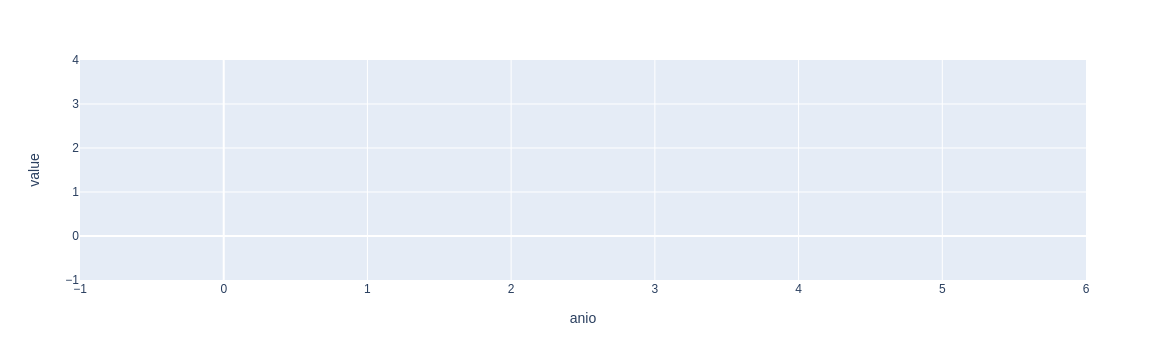

In [ ]:
plot_by_energy('carbon_cons')

In [ ]:
fossil_plot = plot_by_energy('fossil' ,'USA')
petroleo_plot = plot_by_energy('petroleo' ,'USA')
Figure(fossil_plot.data + petroleo_plot.data)

NameError: name 'bad_energies' is not defined

In [ ]:
plot_by_energy('gas', 'USA')

In [ ]:
plot_by_energy('cons', 'USA')